In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models, layers
import numpy as np
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "potato_disease",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 3261 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Early_Blight', 'Healthy', 'Late_Blight']

In [5]:
len(dataset)

102

In [6]:
102*32

3264

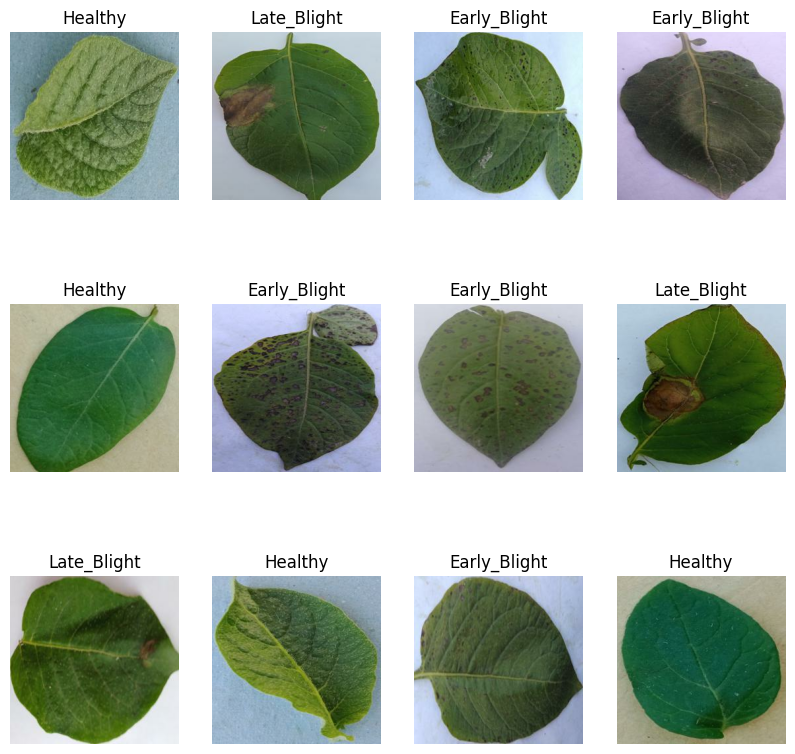

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [8]:
len(dataset)

102

In [9]:
train_size = 0.8
len(dataset)*train_size

81.60000000000001

In [10]:
train_ds = dataset.take(81)
len(train_ds)

81

In [11]:
test_val_ds = dataset.skip(81)
len(test_val_ds)

21

In [12]:
val_size = 0.1
len(dataset)*val_size

10.200000000000001

In [13]:
val_ds = test_val_ds.take(10)
len(val_ds)

10

In [14]:
test_ds = test_val_ds.skip(10)
len(test_ds)

11

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

81

In [18]:
len(val_ds)

10

In [19]:
len(test_ds)

11

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) 
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [22]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape = input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [25]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/10
81/81 [==============================] - 1544s 17s/step - loss: 0.9740 - accuracy: 0.4983 - val_loss: 0.8721 - val_accuracy: 0.5906
Epoch 2/10
81/81 [==============================] - 933s 11s/step - loss: 0.8715 - accuracy: 0.5744 - val_loss: 0.7513 - val_accuracy: 0.7188
Epoch 3/10
81/81 [==============================] - 1023s 13s/step - loss: 0.7603 - accuracy: 0.6891 - val_loss: 0.6240 - val_accuracy: 0.7531
Epoch 4/10
81/81 [==============================] - 999s 12s/step - loss: 0.7003 - accuracy: 0.7146 - val_loss: 0.5953 - val_accuracy: 0.7781
Epoch 5/10
81/81 [==============================] - 865s 11s/step - loss: 0.5014 - accuracy: 0.8046 - val_loss: 0.4311 - val_accuracy: 0.8438
Epoch 6/10
81/81 [==============================] - 1001s 12s/step - loss: 0.3522 - accuracy: 0.8694 - val_loss: 0.3821 - val_accuracy: 0.8406
Epoch 7/10
81/81 [==============================] - 1014s 13s/step - loss: 0.2948 - accuracy: 0.8868 - val_loss: 0.2647 - val_accuracy: 0.9031
Ep

In [36]:
scores = model.evaluate(test_ds)
scores

11/11 [==============================] - 27s 3s/step - loss: 0.1397 - accuracy: 0.9460


[0.13972514867782593, 0.9460227489471436]

In [38]:
history

In [29]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 81}

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

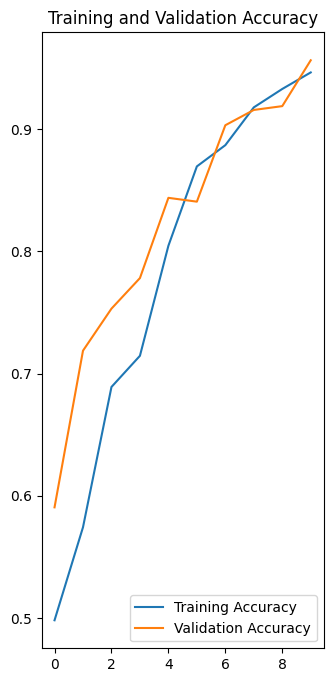

In [31]:
plt.figure(figsize=(8, 8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

first image to predict
Actual label: Late_Blight
1/1 [==============================] - 13s 13s/step
Predicted label: Late_Blight


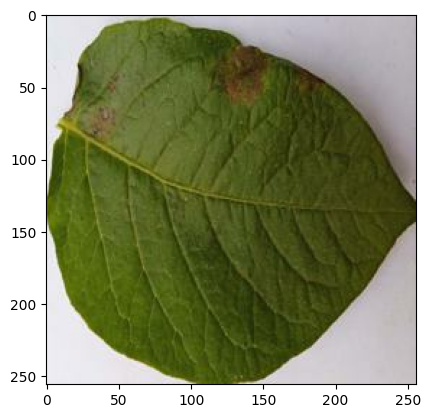

In [32]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = (images_batch[0].numpy().astype('uint8'))
    first_label = labels_batch[0].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print("Actual label:",class_names[first_label])
    batch_prediction = model.predict(images_batch)
    print("Predicted label:", class_names[np.argmax(batch_prediction[0])])

In [33]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 184ms/step


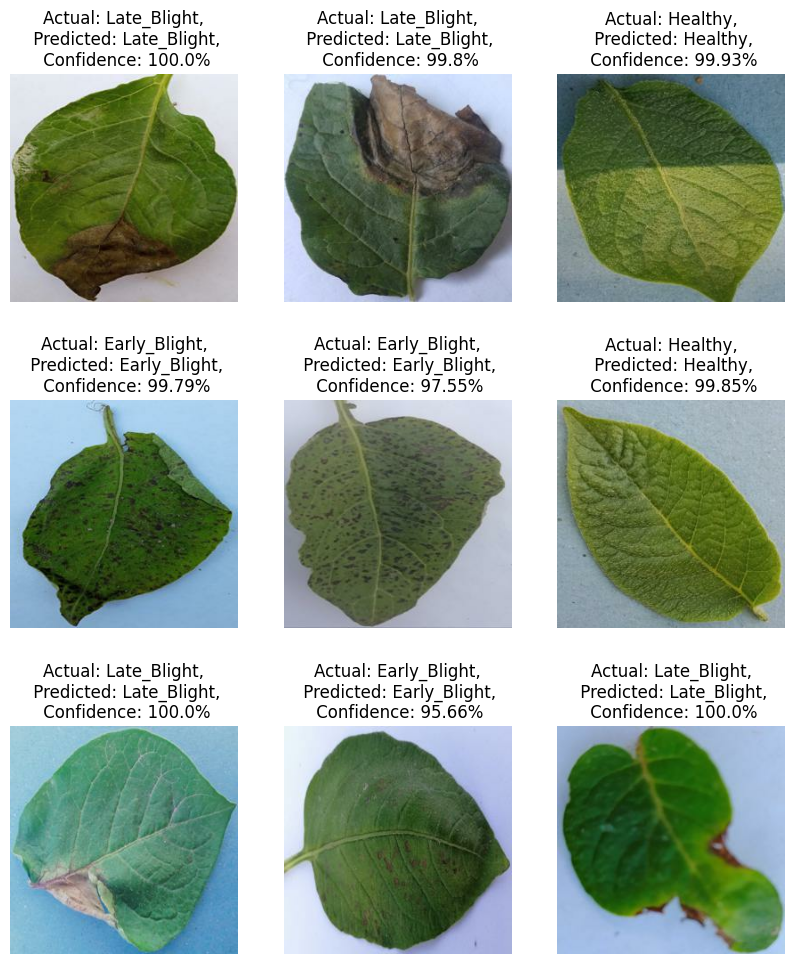

In [34]:
plt.figure(figsize=(10, 12))
for images, labels in test_ds.take(2):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}%")
        plt.axis("off")

In [41]:
import os
#model_version= max([int(i) for i in os.listdir("../models") + [0]])+1
#model.save(f"../models/{model_version}.keras")
model.save(f"../models/pdds.h5")